In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv('../data/raw/train.csv')

In [3]:
train_df.head(10)

,business_id,labels
0,1000,1 2 3 4 5 6 7
1,1001,0 1 6 8
2,100,1 2 4 5 6 7
3,1006,1 2 4 5 6
4,1010,0 6 8
5,101,1 2 3 4 5 6
6,1011,2 3 5 6
7,1012,1 2 3 5 6
8,1014,1 2 4 5 6
9,1015,1 5 6 7


In [4]:
len(train_df)

2000

In [5]:
np.max(sorted(train_df.business_id))

4000

In [6]:
len(set(train_df.business_id))

2000

It seems there are only 2000 different buisiness types.

In [7]:
train_photo_to_biz = pd.read_csv('../data/raw/train_photo_to_biz_ids.csv')

In [8]:
len(train_photo_to_biz)

234842

In [9]:
train_photo_to_biz.head(10)

,photo_id,business_id
0,204149,3034
1,52779,2805
2,278973,485
3,195284,485
4,19992,485
5,80748,485
6,444996,1783
7,200285,35
8,90572,35
9,27565,1313


In [10]:
len(set(train_photo_to_biz.photo_id))

234842

In [11]:
len(set(train_photo_to_biz.business_id))

2000

In [12]:
train_photo_to_biz.groupby('business_id').count().describe()

,photo_id
count,2000.000000
mean,117.421000
std,205.032768
min,2.000000
25%,34.000000
50%,61.000000
75%,117.000000
max,2974.000000


In [13]:
n_photos_per_biz_id = list(train_photo_to_biz.groupby('business_id').count().photo_id)

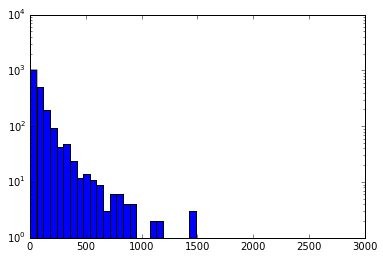

In [14]:
_ = plt.hist(sorted(n_photos_per_biz_id), log=True, bins=50)

Just looking if we could predict directly the business ID.
Data are not balanced correctly, and there are not many images per classes.

In [15]:
test_photo_to_biz = pd.read_csv('../data/raw/test_photo_to_biz.csv')

In [16]:
test_photo_to_biz.head(10)

,photo_id,business_id
0,317818,003sg
1,30679,003sg
2,455084,003sg
3,371381,003sg
4,86224,003sg
5,36076,003sg
6,46999,003sg
7,74896,003sg
8,169399,003sg
9,110581,003sg


In [17]:
len(set(test_photo_to_biz.photo_id))

237152

In [18]:
len(set(test_photo_to_biz.business_id))

10000

There are more test business id than training, so we really need to predict the label and then match them to their business id.

In [19]:
test_n_photos_per_biz_id = list(test_photo_to_biz.groupby('business_id').count().photo_id)

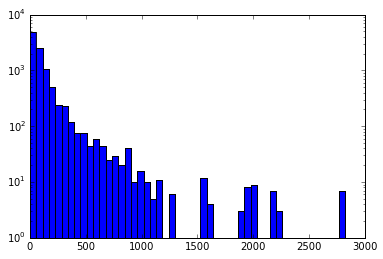

In [20]:
_ = plt.hist(sorted(test_n_photos_per_biz_id), log=True, bins=50)

It seems that we can do the prediction in the following way:
* predict probabilities of each label for every image (multi-label, attibutes are not mutually exclusive)
* merge probabilities for a given business_id.

In [21]:
attribute_id_to_label = {
    0: 'good_for_lunch',
    1: 'good_for_dinner',
    2: 'takes_reservations',
    3: 'outdoor_seating',
    4: 'restaurant_is_expensive',
    5: 'has_alcohol',
    6: 'has_table_service',
    7: 'ambience_is_classy',
    8: 'good_for_kids'}

In [22]:
import json

In [23]:
with open('../data/attribute_id_to_label.json', 'w') as jfile:
    json.dump(attribute_id_to_label, jfile, indent=2)

Prepare training data

For each image, we want a vector 9x1x1 with 1 if the image has the attribute, 0 otherwise

In [24]:
train_photo_id_to_biz_id = dict(zip(train_photo_to_biz.photo_id, train_photo_to_biz.business_id))

In [25]:
train_df_cleaned = train_df.dropna()

In [26]:
len(train_df_cleaned)

1996

In [27]:
len(train_df)

2000

In [28]:
biz_id_to_labels_str = dict(zip(train_df_cleaned.business_id, train_df_cleaned['labels']))

In [29]:
biz_id_to_labels = dict()
for biz_id, labels_str in biz_id_to_labels_str.items():
    biz_id_to_labels[biz_id] = [int(l) for l in labels_str.split()]

In [30]:
def OHE(labels, size=9):
    ohe = np.zeros((9, 1, 1))
    for l in labels:
        ohe[l][0][0] = 1
    return ohe

In [31]:
biz_id_to_ohe_labels = dict()
for biz_id, labels in biz_id_to_labels.items():
    biz_id_to_ohe_labels[biz_id] = OHE(labels)

In [32]:
train_photo_id_to_ohe_labels = dict()
for photo_id, biz_id in train_photo_id_to_biz_id.items():
    if biz_id in biz_id_to_ohe_labels:
        train_photo_id_to_ohe_labels[photo_id] = biz_id_to_ohe_labels[biz_id]

In [33]:
len(train_photo_id_to_ohe_labels)

234545

# Check labels distributions

In [34]:
counts = {i: 0 for i in range(9)}

In [35]:
for _, biz_id in train_photo_id_to_biz_id.items():
    if biz_id in biz_id_to_labels:
        for l in biz_id_to_labels[biz_id]:
            counts[l] += 1

In [36]:
counts

{0: 53554,
 1: 139557,
 2: 150945,
 3: 114706,
 4: 99136,
 5: 173203,
 6: 180849,
 7: 87325,
 8: 118903}

<Container object of 9 artists>

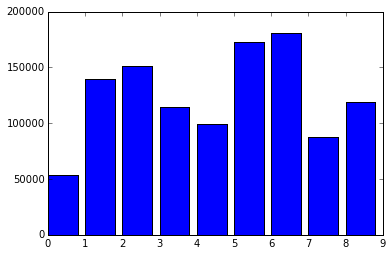

In [37]:
plt.bar(counts.keys(), counts.values())

# Check labels co-occurences

In [38]:
co = np.zeros((9, 9))
for _, biz_id in train_photo_id_to_biz_id.items():
    if biz_id in biz_id_to_labels:
        for l1 in biz_id_to_labels[biz_id]:
            for l2 in biz_id_to_labels[biz_id]:
                co[l1][l2] += 1

In [39]:
co_norm = np.zeros((9, 9))
r, c = co.shape
for i in range(r):
    for j in range(c):
        co_norm[i][j] = co[i][j]/co[i][i]

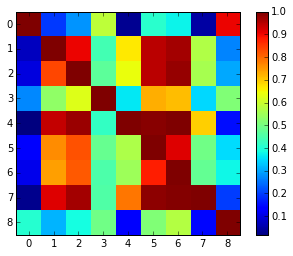

In [40]:
fig = plt.figure()
#plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(co_norm, cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = co_norm.shape

cb = fig.colorbar(res)
_ = plt.xticks(range(width), [str(i) for i in range(width)])
_ = plt.yticks(range(height), [str(i) for i in range(width)])
#plt.savefig('confusion_matrix.png', format='png')

It seems that some labels appears quite often together (0 and 8, 1 and 6, ...), some quite rarely (4 and 8)

In [41]:
attribute_id_to_label[0]

'good_for_lunch'

In [42]:
attribute_id_to_label[7]

'ambience_is_classy'

In [43]:
attribute_id_to_label[8]

'good_for_kids'

# Split in train/val

We want to predict label for biz id, so I will also split the traning set on buisiness id.

In [ ]:
seed = 42

In [56]:
np.random.seed(42)

In [57]:
train_biz_id = set(train_photo_to_biz.business_id)

In [58]:
len(train_biz_id)

2000

In [59]:
train_ratio = 0.7

In [60]:
train_biz_id_permuted = np.random.permutation(list(train_biz_id))

In [61]:
n_train_biz_id = int(len(train_biz_id) * train_ratio)

In [62]:
train_biz_id_cv = set(train_biz_id_permuted[:n_train_biz_id])
val_biz_id_cv = set(train_biz_id_permuted[n_train_biz_id:])

In [63]:
train_photos_ids_cv = {photo_id for photo_id, biz_id in train_photo_id_to_biz_id.items() if biz_id in train_biz_id_cv}
val_photos_ids_cv = {photo_id for photo_id, biz_id in train_photo_id_to_biz_id.items() if biz_id in val_biz_id_cv}

In [64]:
len(train_photos_ids_cv)

163202

In [65]:
len(val_photos_ids_cv)

71640

In [66]:
171597.0/len(train_photo_id_to_biz_id)

0.7306912732816107

Ok, still about 70% in the training set

In [67]:
train_photo_id_to_ohe_labels_cv = {photo_id: ohe for photo_id, ohe in train_photo_id_to_ohe_labels.items() if photo_id in train_photos_ids_cv}
val_photo_id_to_ohe_labels_cv = {photo_id: ohe for photo_id, ohe in train_photo_id_to_ohe_labels.items() if photo_id in val_photos_ids_cv}

# Check if images files are on disk

In [68]:
!find ./data/raw/train_photos/ -name '*.jpg'  >> ../data/raw/train_photos.list

find: ./data/raw/train_photos/: No such file or directory


In [69]:
!find ./data/raw/test_photos/ -name '*.jpg'  >> ../data/raw/test_photos.list

find: ./data/raw/test_photos/: No such file or directory


In [70]:
train_photo_ids_available = set()
with open('../data/raw/train_photos.list', 'r') as lfile:
    for line in lfile:
        path = line.strip()
        _, basename = os.path.split()
        id_str, _ = os.path.splitext()
        train_photo_ids_available.add(int(id_str))

# Create train/val LMDB

In [72]:
import caffe
import lmdb

In [76]:
def create_labels_lmdb(photo_id_to_ohe_labels, lmdb_filename):
    counter_label = 0
    db_labels = lmdb.open(lmdb_filename, map_size=1e12)
    with db_labels.begin(write=True) as txn_label:
        for _, ohe in photo_id_to_ohe_labels.items():
            datum = caffe.io.array_to_datum(ohe)
            txn_label.put("{:0>10d}".format(counter_label), datum.SerializeToString())
            counter_label += 1   
    db_labels.close()

In [77]:
create_labels_lmdb(train_photo_id_to_ohe_labels_cv, '../data/db/train_labels_lmdb')

In [78]:
create_labels_lmdb(val_photo_id_to_ohe_labels_cv, '../data/db/val_labels_lmdb')

In [79]:
def create_caffe_image_file(photo_id_to_ohe_labels, filename):
    with open(filename, 'w') as cfile:
        for photo_id, _ in photo_id_to_ohe_labels.items():
            cfile.write("{id}.jpg 0\n".format(id=photo_id))

In [80]:
create_caffe_image_file(train_photo_id_to_ohe_labels_cv, '../data/db/train_caffe.txt')

In [81]:
create_caffe_image_file(val_photo_id_to_ohe_labels_cv, '../data/db/val_caffe.txt')

In [82]:
!head -n 5 ../data/db/train_caffe.txt

262144.jpg 0
462639.jpg 0
2.jpg 0
436907.jpg 0
460541.jpg 0


In [83]:
!wc -l ../data/db/train_caffe.txt

  162905 ../data/db/train_caffe.txt


In [84]:
!wc -l ../data/db/val_caffe.txt

   71640 ../data/db/val_caffe.txt


In [85]:
162905/256.0

636.34765625

In [86]:
71640/64.0

1119.375

In [87]:
637*20

12740

In [88]:
60*637

38220